# Подключение библиотек

In [204]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math

from pandas import Series, DataFrame 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

%matplotlib inline

RANDOM_STATE = 42

# Препроцессинг

## Всякие функции

In [205]:
def memory_analyse(df):
    for dtype in ['float','int','object']:
        selected_dtype = df.select_dtypes(include=[dtype])
        mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
        mean_usage_mb = mean_usage_b / 1024 ** 2
        print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

def show_data(df):
    for col in df.columns:
        print("{0}: {1}".format(col, df[col].unique()))
    print(df.columns)               
            
def find_NaN(df, pr=False):
    nan = df.loc[:, df.isnull().any()].copy()
    if pr:
        print(nan.columns)
    nans = nan.isna().sum()
    if pr:
        print(nans)
    return nan.columns

def uniq_ratio(train, test):
    df = pd.concat([train, test], axis=0, ignore_index=True)
    nans = find_NaN(df)
    
    l = df.shape[0]
    ratio = dict()
    
    for col in nans:        
        if df[col].dtype == 'object':
            uniqs = train[col].dropna().unique()
            rats = []
            for u in uniqs:
                rats.append((u, df[df[col] == u][[col]].shape[0] / l))
            rats.append(('NaN', df[col].isna().sum() / l))
            ratio[col] = rats
    return ratio

def make_data(train, test, unnes):    
    train_ = train.drop(unnes, axis=1)
    test_ = test.drop(unnes, axis=1)
    
    target = train_['Segmentation']
    train_ = train_.drop(['Segmentation'], axis=1)
        
    df = pd.concat([train_, test_], axis=0, ignore_index=True)
    nans = find_NaN(df)
    
    for col in nans:        
        if df[col].dtype == 'object':
            train_[col].fillna(df[col].value_counts().index[0], inplace=True)
            test_[col].fillna(df[col].value_counts().index[0], inplace=True)
        else:
            train_[col].fillna(np.median(df[col].dropna().values), inplace=True)
            test_[col].fillna(np.median(df[col].dropna().values), inplace=True)
    
    for col in train_.columns:
        if df[col].dtype == 'object':
            train_[col].replace(train_[col].dropna().unique(), [i for i in range(train_[col].dropna().nunique())], inplace=True)
            test_[col].replace(test_[col].dropna().unique(), [i for i in range(test_[col].dropna().nunique())], inplace=True)
            
    for col in train_.columns:
        train_[col] = (train_[col] - train_[col].mean()) / math.sqrt(train_[col].std())
        test_[col] = (test_[col] - test_[col].mean()) / math.sqrt(test_[col].std())
    
    return train_, test_, target

## Обработка данных

In [206]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [207]:
train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [208]:
train.shape

(8068, 11)

In [209]:
train.dtypes

ID                   int64
Gender              object
Ever_Married        object
Age                  int64
Graduated           object
Profession          object
Work_Experience    float64
Spending_Score      object
Family_Size        float64
Var_1               object
Segmentation        object
dtype: object

In [210]:
train.describe()

,ID,Age,Work_Experience,Family_Size
count,8068.000000,8068.000000,7239.000000,7733.000000
mean,463479.214551,43.466906,2.641663,2.850123
std,2595.381232,16.711696,3.406763,1.531413
min,458982.000000,18.000000,0.000000,1.000000
25%,461240.750000,30.000000,0.000000,2.000000
50%,463472.500000,40.000000,1.000000,3.000000
75%,465744.250000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


In [211]:
train.describe(include=['object'])

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
count,8068,7928,7990,7944,8068,7992,8068
unique,2,2,2,9,3,7,4
top,Male,Yes,Yes,Artist,Low,Cat_6,D
freq,4417,4643,4968,2516,4878,5238,2268


In [212]:
unique_counts = pd.DataFrame.from_records([(col, train[col].dtype, train[col].nunique()) for col in train.columns],
                          columns=['Column_Name', 'Type', 'Num_Unique']).sort_values(by=['Num_Unique'])
unique_counts

,Column_Name,Type,Num_Unique
1,Gender,object,2
2,Ever_Married,object,2
4,Graduated,object,2
7,Spending_Score,object,3
10,Segmentation,object,4
9,Var_1,object,7
5,Profession,object,9
8,Family_Size,float64,9
6,Work_Experience,float64,15
3,Age,int64,67


In [213]:
unnes = ['ID']

In [214]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
ID                 8068 non-null int64
Gender             8068 non-null object
Ever_Married       7928 non-null object
Age                8068 non-null int64
Graduated          7990 non-null object
Profession         7944 non-null object
Work_Experience    7239 non-null float64
Spending_Score     8068 non-null object
Family_Size        7733 non-null float64
Var_1              7992 non-null object
Segmentation       8068 non-null object
dtypes: float64(2), int64(2), object(7)
memory usage: 693.4+ KB


In [215]:
memory_analyse(train)

Average memory usage for float columns: 0.04 MB
Average memory usage for int columns: 0.04 MB
Average memory usage for object columns: 0.42 MB


In [216]:
for col in train.columns:
    if (train[col].dtype == int) & (col != "ID"):
        train[col] = train[col].astype('int8')
        test[col] = test[col].astype('int8')
    elif (train[col].dtype == float):
        train[col] = train[col].astype('float16')
        test[col] = test[col].astype('float16')
        
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
ID                 8068 non-null int64
Gender             8068 non-null object
Ever_Married       7928 non-null object
Age                8068 non-null int8
Graduated          7990 non-null object
Profession         7944 non-null object
Work_Experience    7239 non-null float16
Spending_Score     8068 non-null object
Family_Size        7733 non-null float16
Var_1              7992 non-null object
Segmentation       8068 non-null object
dtypes: float16(2), int64(1), int8(1), object(7)
memory usage: 543.7+ KB


In [217]:
memory_analyse(train)

Average memory usage for float columns: 0.00 MB
Average memory usage for int columns: 0.03 MB
Average memory usage for object columns: 0.42 MB


In [218]:
obj_cols = [col for col in train.columns if train[col].dtype == object]
obj_cols

['Gender',
 'Ever_Married',
 'Graduated',
 'Profession',
 'Spending_Score',
 'Var_1',
 'Segmentation']

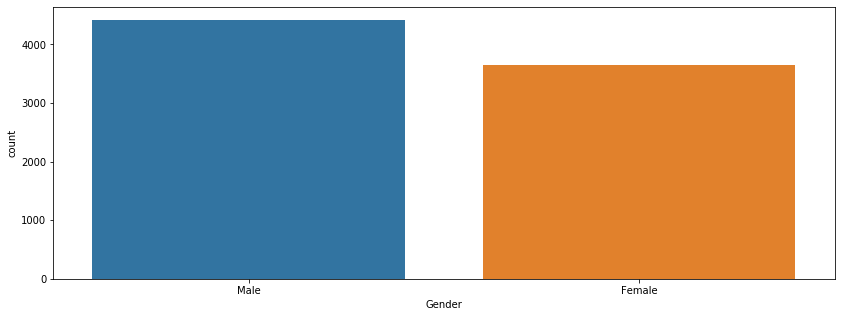

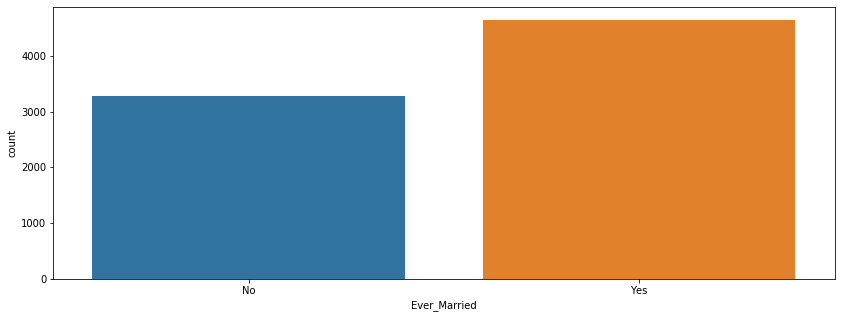

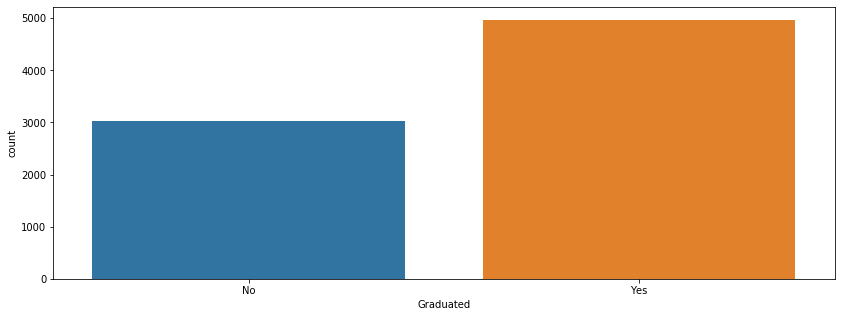

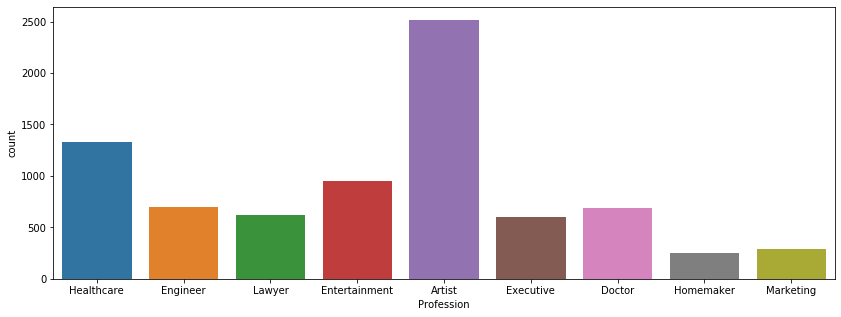

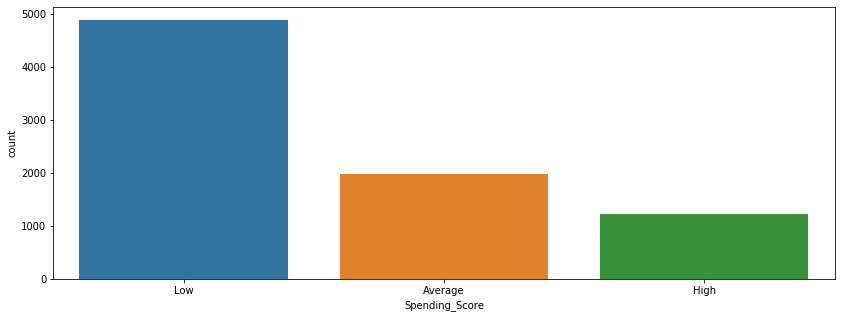

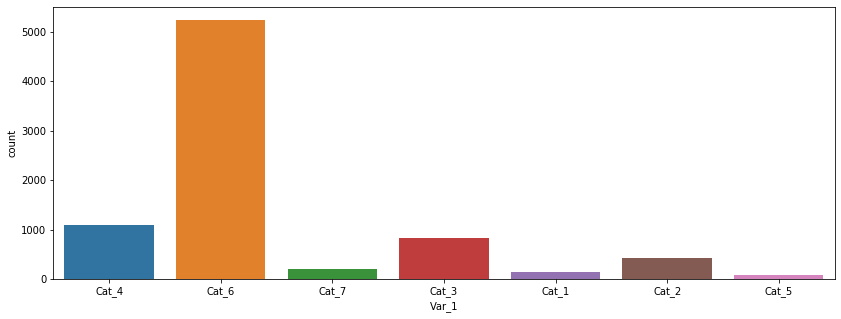

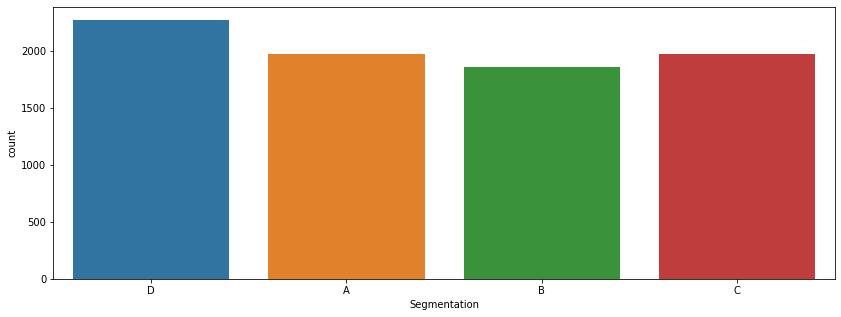

In [219]:
for col in obj_cols:    
    fig = plt.figure(figsize= (14,5))
    sns.countplot(train[col])

In [220]:
train.Segmentation.replace(train.Segmentation.unique(), [i for i in range(train.Segmentation.nunique())], inplace=True)

In [221]:
train['Segmentation'] = train['Segmentation'].astype('int8')

In [222]:
num_cols = list(set(train.columns) - set(obj_cols))
num_cols.append('Segmentation')
num_cols

['Age', 'ID', 'Work_Experience', 'Family_Size', 'Segmentation']

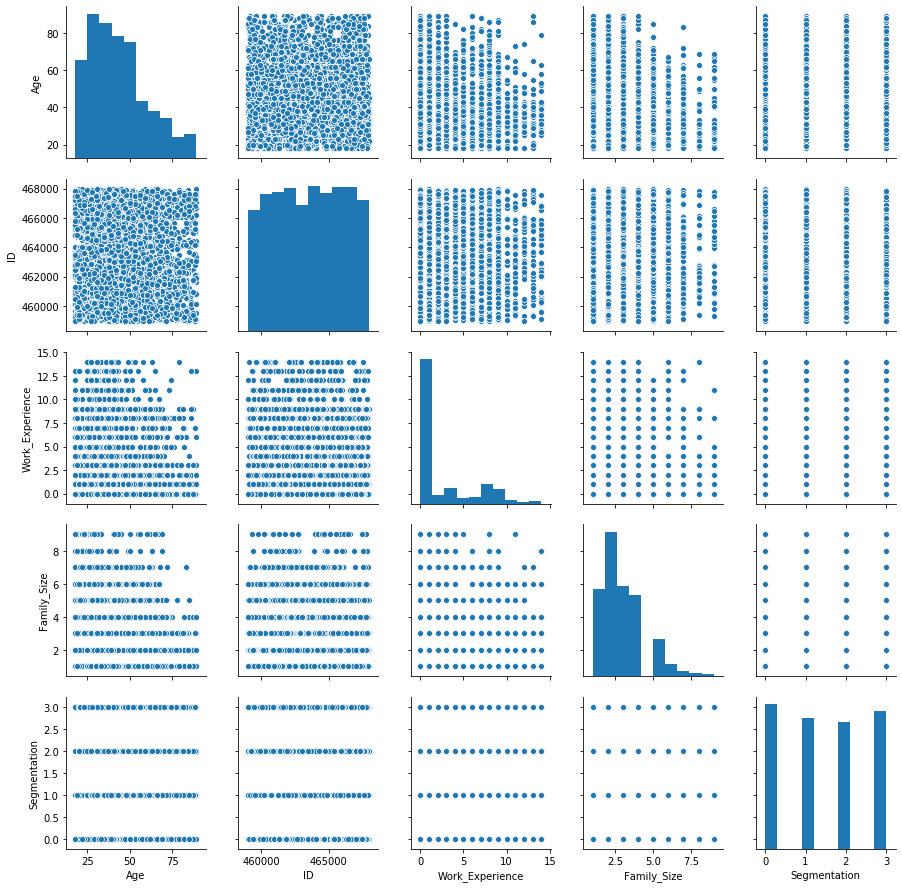

In [223]:
sns_plot = sns.pairplot(train[num_cols].dropna())

In [224]:
train.corr()

,ID,Age,Work_Experience,Family_Size,Segmentation
ID,1.000000,-0.005055,-0.030688,0.011801,0.028634
Age,-0.005055,1.000000,-0.190789,-0.280517,0.351848
Work_Experience,-0.030688,-0.190789,1.000000,-0.063234,-0.094254
Family_Size,0.011801,-0.280517,-0.063234,1.000000,-0.045118
Segmentation,0.028634,0.351848,-0.094254,-0.045118,1.000000


<Figure size 2880x2880 with 0 Axes>

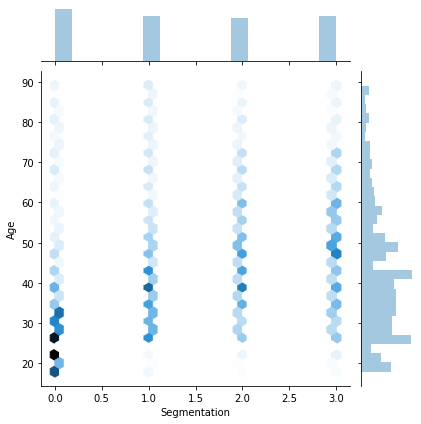

<Figure size 2880x2880 with 0 Axes>

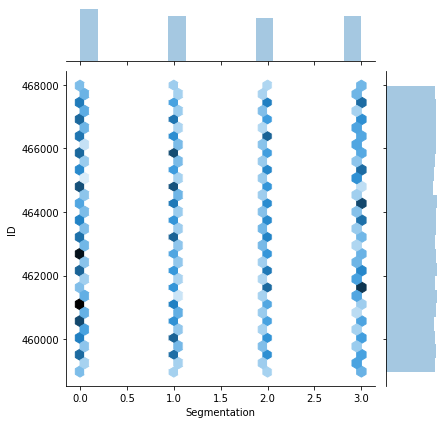

<Figure size 2880x2880 with 0 Axes>

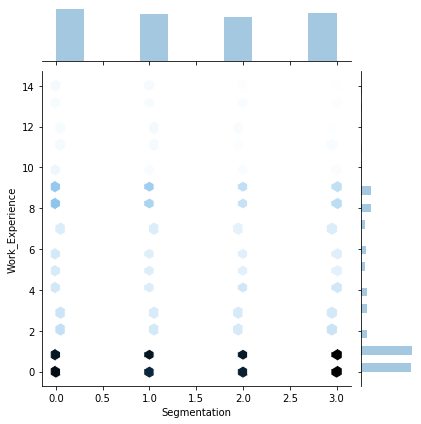

<Figure size 2880x2880 with 0 Axes>

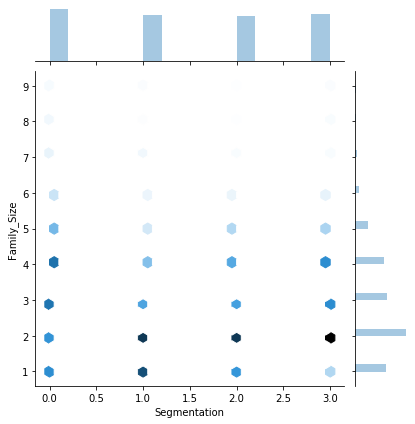

<Figure size 2880x2880 with 0 Axes>

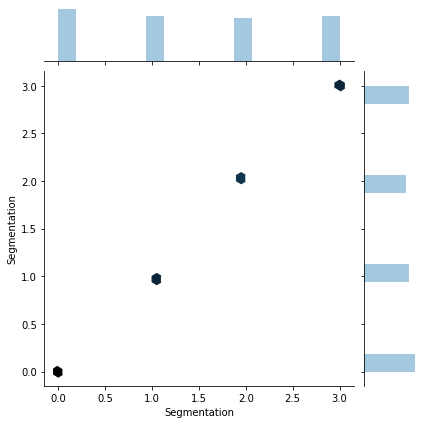

In [225]:
for col in num_cols:
    fig = plt.figure(figsize=(40, 40))
    sns.jointplot(x='Segmentation', y=col, data=train, kind ='hex',gridsize=30)

In [226]:
unnes.append('Work_Experience')

In [227]:
obj_cols.remove('Segmentation')

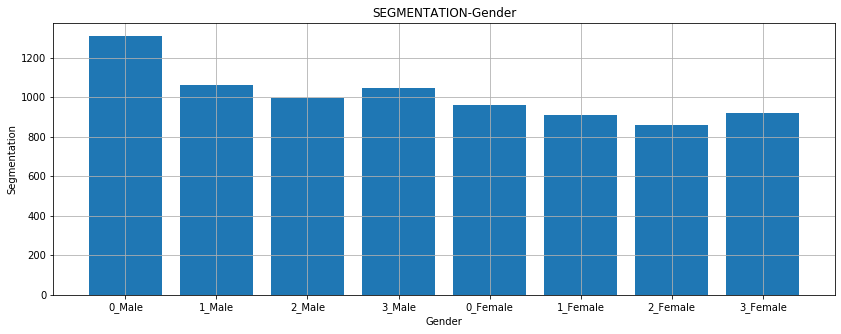

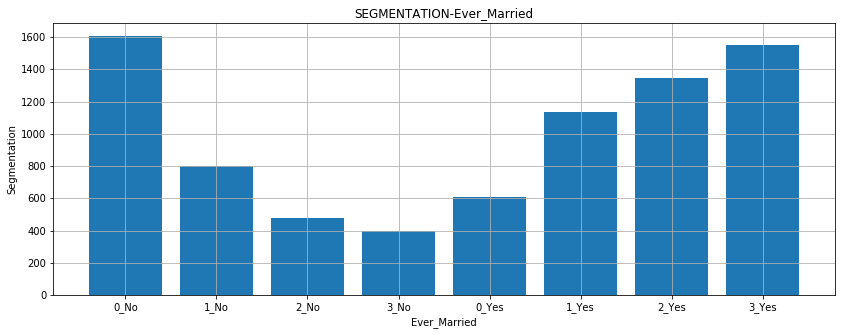

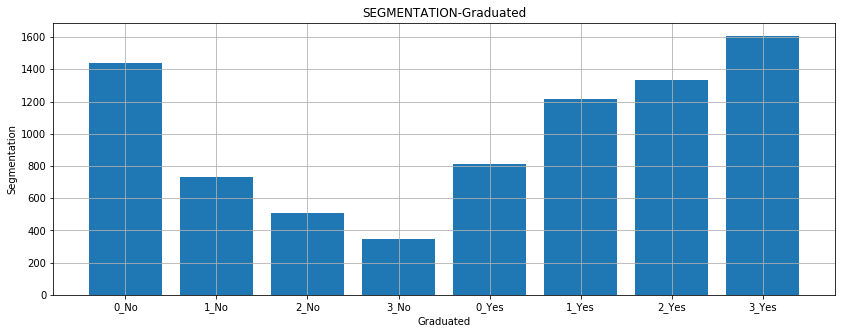

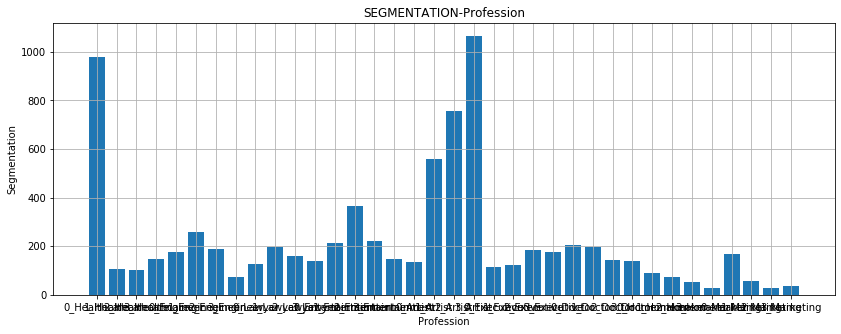

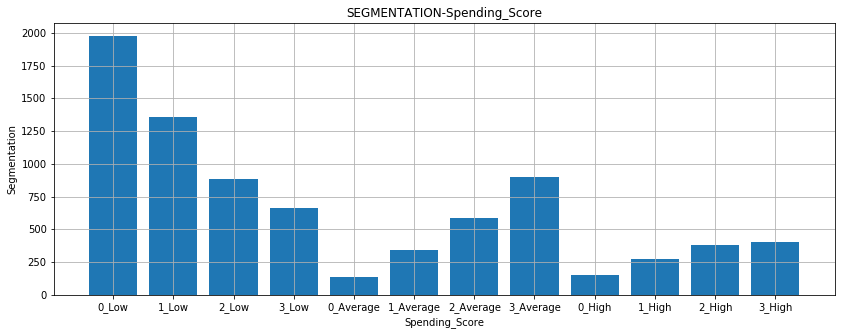

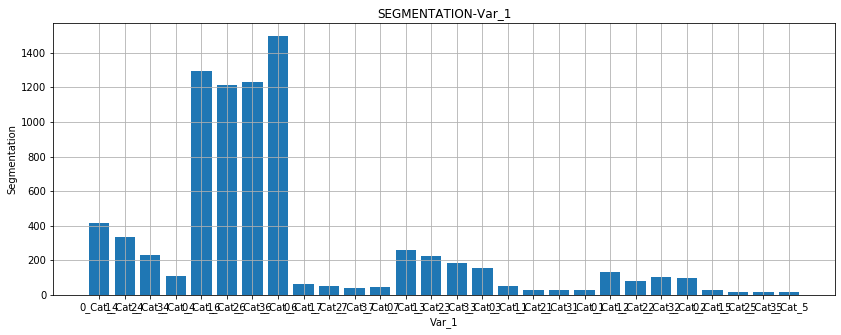

In [228]:
for col in obj_cols:
    uniqs = train[col].dropna().unique()
    cls = ["{0}_{1}".format(i % 4, uniqs[i // 4]) for i in range(len(uniqs) * 4)]
    
    values = []
    
    for uniq in uniqs:
        for i in range(4):
            values.append(train[(train[col] == uniq) & (train.Segmentation == i)][['Segmentation']].Segmentation.count())
    
    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot()
    ax1.set_xlabel(col)
    ax1.set_ylabel('Segmentation')
    ax1.set_title('SEGMENTATION-{}'.format(col))
    ax1.grid()
    ax1.bar(cls, values) 

In [229]:
unnes.append('Gender')

In [230]:
train_NaN = find_NaN(train, True)

Index(['Ever_Married', 'Graduated', 'Profession', 'Work_Experience',
       'Family_Size', 'Var_1'],
      dtype='object')
Ever_Married       140
Graduated           78
Profession         124
Work_Experience    829
Family_Size        335
Var_1               76
dtype: int64


In [231]:
test_NaN = find_NaN(test, True)
test.shape[0]

Index(['Ever_Married', 'Graduated', 'Profession', 'Work_Experience',
       'Family_Size', 'Var_1'],
      dtype='object')
Ever_Married        50
Graduated           24
Profession          38
Work_Experience    269
Family_Size        113
Var_1               32
dtype: int64


2627

In [232]:
train_NaN = list(set(train_NaN) - set(unnes))
test_NaN = list(set(test_NaN) - set(unnes))

In [233]:
ratio = uniq_ratio(train, test)

In [234]:
ratio

{'Ever_Married': [('No', 0.4059841047218326),
  ('Yes', 0.5762505843852267),
  ('NaN', 0.017765310892940627)],
 'Graduated': [('No', 0.3761570827489481),
  ('Yes', 0.6143057503506312),
  ('NaN', 0.009537166900420757)],
 'Profession': [('Healthcare', 0.16362786348761102),
  ('Engineer', 0.08742402992052362),
  ('Lawyer', 0.07891538101916784),
  ('Entertainment', 0.1168770453482936),
  ('Artist', 0.31023842917251054),
  ('Executive', 0.07246376811594203),
  ('Doctor', 0.08695652173913043),
  ('Homemaker', 0.03066853669939224),
  ('Marketing', 0.03768115942028986),
  ('NaN', 0.01514726507713885)],
 'Var_1': [('Cat_4', 0.13791491351098645),
  ('Cat_6', 0.646096306685367),
  ('Cat_7', 0.025151940158952783),
  ('Cat_3', 0.10182328190743338),
  ('Cat_1', 0.015614773258532024),
  ('Cat_2', 0.052641421224871435),
  ('Cat_5', 0.010659186535764377),
  ('NaN', 0.010098176718092567)]}

In [235]:
X, Y, target = make_data(train, test, unnes)

In [236]:
X.head()

,Ever_Married,Age,Graduated,Profession,Spending_Score,Family_Size,Var_1
0,-0.845756,-5.251208,-0.898960,-2.244226,-0.634323,0.934570,-1.239516
1,0.580871,-1.337308,0.538378,-1.561815,0.527211,0.118042,-1.239516
2,0.580871,5.756636,0.538378,-1.561815,-0.634323,-1.515625,-0.357490
3,0.580871,5.756636,0.538378,-0.879404,1.688744,-0.698730,-0.357490
4,0.580871,-0.848070,0.538378,-0.196993,1.688744,2.568359,-0.357490


# K-means ++

## Реализация

In [237]:
# евклидово расстояние
def l(x1, x2):
    return (x1 - x2).dot(x1 - x2)

In [238]:
# кластер
class K:
    # инициализация
        # centroid - центроид
        # objects - индексы объектов кластера
        # n - размер кластера
    def __init__(self):
        self.centroid = None
        self.objects = []
        self.n = 0
    # задать центроид
    def set_centroid(self, c):
        self.centroid = c
    # добавить объект кластера    
    def set_object(self, obj):
        self.objects.append(obj)
        self.n += 1
    # очистить кластер от объектов    
    def remove_objects(self):
        self.objects = []
        self.n = 0
    # пересчитать центроид
    def calculate_centroid(self, X):
        self.centroid = sum([X[i] for i in self.objects]) / self.n

In [239]:
# K-means ++
class kMeans:
    # инициализация
        # X - выборка
        # p - количество кластеров
        # epsilon - порог остановы
        # Ks - мн-во кластеров
        # d - функция подсчета расстояний
    def __init__(self, p=3, epsilon=0.01, d=l):
        self.X = None
        self.p = p
        self.epsilon = 0.001
        self.Ks = [K() for i in range(p)]
        self.d = d
        self.l = 0
    # инициализация кластеров    
    def fit(self, X):
        self.X = np.array(X)
        
        ind = random.randint(0, len(self.X))
        self.Ks[0].set_centroid(self.X[ind])
        
        l2 = [self.d(self.X[i], self.Ks[0].centroid) ** 2 for i in range(len(self.X))]
        L2 = sum(l2)
        u = [random.random() * L2 for i in range(self.p)]
        
        for s in range(1, self.p):
            k = 0
            while sum(l2[:k]) < u[s]:
                k += 1
            self.Ks[s].set_centroid(self.X[k])
    # разбиение по кластерам
    def predict(self):
        centroids = self._all_c()
        eps = 1.
        
        while eps > self.epsilon:
            self._new_clusters()
            self.l = 0
            
            for i in range(len(self.X)):
                dist = np.array([self.d(self.X[i], centroids[s]) for s in range(self.p)])
                self.l += np.min(dist) ** 2
                s = np.argmin(dist)
                self.Ks[s].set_object(i)
                
            for k in self.Ks:
                k.calculate_centroid(self.X)
            
            eps = self._eps(centroids, self._all_c())
            centroids = self._all_c()
            
        return self.Ks
    # обновление кластеров        
    def _new_clusters(self):
        for k in self.Ks:
            k.remove_objects()
    # подсчет изменения кластеров        
    def _eps(self, c1, c2):
        return sum([np.linalg.norm(c1[i] - c2[i]) for i in range(self.p)])
    # заполнение центроидами
    def _all_c(self):
        return [self.Ks[i].centroid for i in range(self.p)]

## Подбор кол-ва кластеров

In [240]:
p = np.arange(2, 10, 1)

In [241]:
q = []

for s in p:
    m = kMeans(s)
    m.fit(X)
    ks = m.predict()
    q.append(m.l)

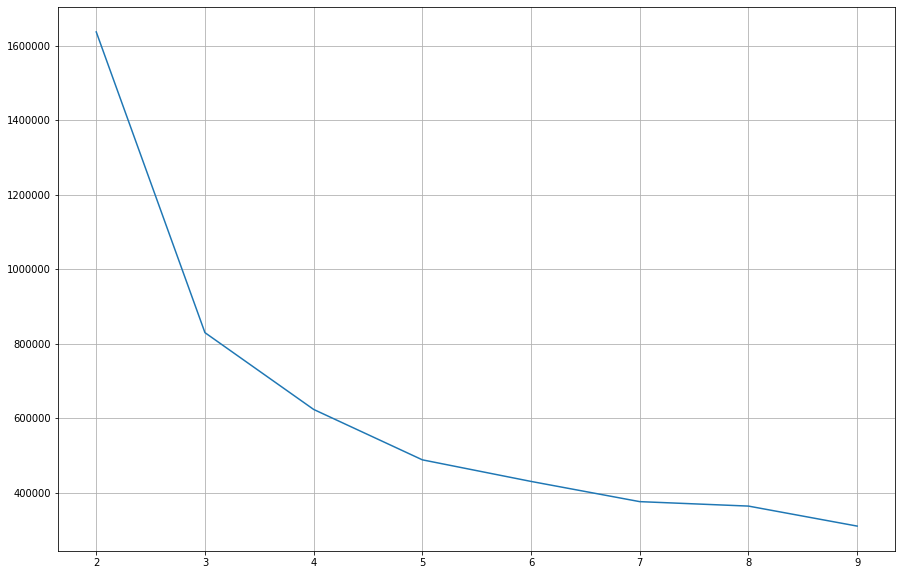

In [242]:
fig = plt.figure(figsize=(15, 10))
plt.grid()
plt.plot(p, q)

# PCA

## Реализация

In [243]:
# метод главных компонент
class PCA:
    # инициализация
        # delta - порог доли объясненной дисперсии
        # C - ковариационная матрица
        # L - собственные значения
        # V - собственные векторы
        # X - выборка
        # Y - главные компоненты
        # Delta - доля объясненной дисперсии для перешедших порог
    def __init__(self, delta=0.8):
        self.delta = delta
        self.C = None
        self.L = None
        self.V = None
        self.X = None
        self.Y = None
        self.Delta = 0.
    # рассчет главных компонент
    def fit(self, X):
        self.X = np.array(X).T
        self.C = np.array(X.cov())
        self.L, self.V = np.linalg.eig(self.C)
        self.Y = self.V.T.dot(self.X)
    # отбор компонент с с заданным порогом    
    def predict(self):
        m = 1
        while True:
            D = sum([self.L[i] for i in range(m)])
            self.Delta = D / sum(self.L)
            if self.Delta < self.delta:
                m += 1
            else:
                break
        return m

## Работа алгоритма

In [244]:
pca = PCA()
pca.fit(X)

In [245]:
pca.predict()

2

In [246]:
pca.Delta

0.8289046227195909

In [247]:
pca.Y.shape

(7, 8068)

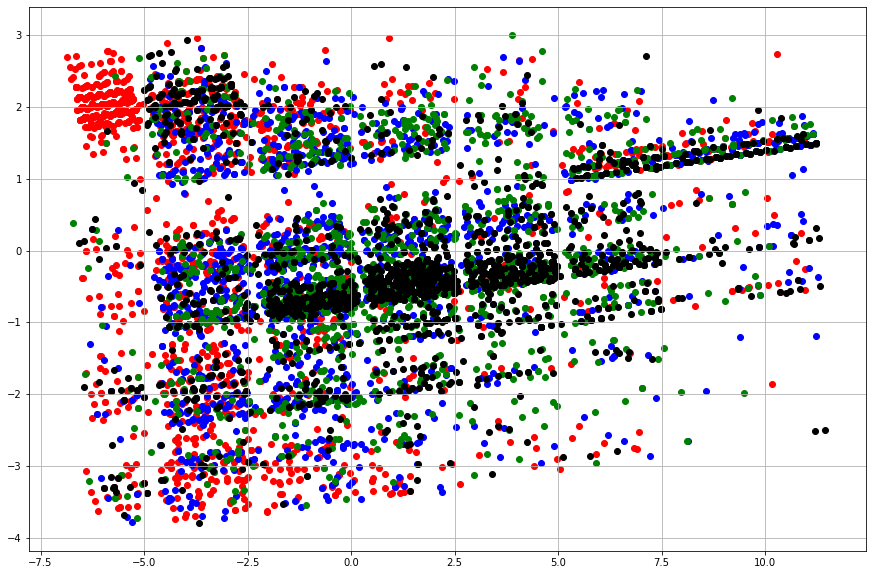

In [248]:
colors = ['red', 'blue', 'green', 'black']

fig = plt.figure(figsize=(15, 10))
plt.grid()
ax = fig.add_subplot(1,1,1) 

for t, c in zip(target.unique(), colors):
    mask = target == t
    ax.scatter(pca.Y[0][mask], pca.Y[1][mask], c=c)

In [249]:
k_means = kMeans(4)
k_means.fit(pca.Y.T)

In [250]:
Ks = k_means.predict()

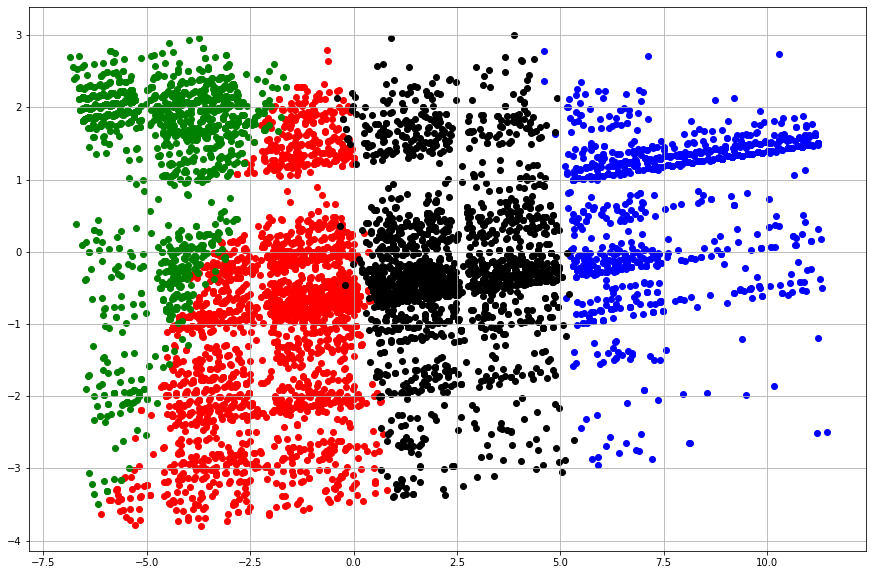

In [251]:
colors = ['red', 'blue', 'green', 'black']

fig = plt.figure(figsize=(15, 10))
plt.grid()
ax = fig.add_subplot(1,1,1) 

for k, c in zip(Ks, colors):
    ax.scatter(pca.Y[0][k.objects], pca.Y[1][k.objects], c=c)

# kNN

In [291]:
X_train, X_test, Y_train, Y_test = train_test_split(X, target, test_size=0.4, random_state=42)

In [292]:
from sklearn.neighbors import KNeighborsClassifier

nn = KNeighborsClassifier(n_neighbors=7)
nn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [293]:
pr = nn.predict(X_test)

In [294]:
accuracy_score(pr, Y_test)

0.476456009913259

## Реализация

In [252]:
# ядро сглаживания
def Ku(u):
    return (3 / 4) * (1 - u * u)
# веса
def w(x, X, i, q):
    return q(x, X[i]) / q(x, X[i + 1])

def g(u):
    return 1

In [315]:
# kNN
class kNN:
    # инициализация:
        # k - кол-во соседей
        # d - функция расстояния
        # Ku - ядро сглаживания
        # w - веса
        # X - обучающая выборка
        # Y - обучающая выборка
        # num_class - кол-во классов
        # preds - предсказанные значения
    def __init__(self, k=3, d=l, Ku=Ku, w=w):
        self.k = k        
        self.d = l
        self.Ku = Ku
        self.w = w
        self.X = None
        self.Y = None
        self.num_class = None
        self.preds = []
    # обучение
    def fit(self, X, Y):
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.num_class = Y.nunique()
    # классификация    
    def predict(self, test):
        test = np.array(test)        
        for y in test:
            X_sorted, Y_sorted = self._sort(y)
            ws = self._weights(y, X_sorted)
            s_ = np.argmax(np.array([sum([ws[i] * self._I(s, Y_sorted[i]) for i in range(self.k)]) for s in range(self.num_class)]))
            self.preds.append(s_)
        return self.preds
    # сортировка по удаленности
    def _sort(self, y):
        XY = zip(self.X, self.Y)
        XY_sorted = sorted(XY, key=lambda tup: self.d(y, tup[0]))
        return np.array([xy[0] for xy in XY_sorted]), np.array([xy[1] for xy in XY_sorted])
    # веса элементов
    def _weights(self, y, X):
        return np.array([self.Ku(self.w(y, X, i, self.d)) for i in range(len(self.X) - 1)] + [0.])
    # принадлежность классу
    def _I(self, s, y):
        if s == y:
            return 1
        return 0

## Работа алгоритма

In [320]:
X_train, X_test, Y_train, Y_test = train_test_split(X, target, test_size=0.4, random_state=42)

In [321]:
knn = kNN(k=7)
knn.fit(X_train, Y_train)

In [322]:
preds = knn.predict(X_test)

In [323]:
accuracy_score(preds, Y_test)

0.3822800495662949

## Работа на пониженной размерности

In [324]:
X_train, X_test, Y_train, Y_test = train_test_split(pca.Y.T[:,:2], target, test_size=0.4, random_state=42)

In [325]:
knn_pca = kNN(k=7)
knn_pca.fit(np.array(X_train)[:,:2], Y_train)

In [326]:
preds = knn_pca.predict(X_test)

In [327]:
accuracy_score(preds, Y_test)

0.3509913258983891

# Наивный Байес

In [300]:
X_train, X_test, Y_train, Y_test = train_test_split(X, target, test_size=0.4, random_state=42)

In [303]:
from sklearn.naive_bayes import GaussianNB

bb = GaussianNB()
bb.fit(X_train, Y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [304]:
pr = bb.predict(X_test)

In [305]:
accuracy_score(pr, Y_test)

0.4804832713754647

## Реализация

In [268]:
# наивный Байесовский классификатор
class Bayes:
    # инициализация:
        # X, Y - обучающая выборка
        # num_class - кол-во классов
        # PKs - вероятности принадлежности классам
        # Px - вероятности для ДСВ
        # preds - предсказанные значения
    def __init__(self):
        self.X = None
        self.Y = None
        self.num_class = None
        self.PKs = []
        self.Px = []
        self.preds = []
    # обучение    
    def fit(self, X, Y):
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.num_class = Y.nunique()
        for i in range(self.num_class):
            mask = self.Y == i
            self.PKs.append(len(self.Y[mask]) / len(self.Y))
            row = []
            for i in range(self.X.shape[1]):
                d = dict()
                for u in uniq:
                    d[u] = len(self.X[mask][:,i][self.X[mask][:,i] == u]) / len(self.X[mask])
                row.append(d)
            self.Px.append(row)
    # классификация
    def predict(self, test):
        test = np.array(test)
        for y in test:
            s = []
            for i in range(self.num_class):
                s.append(self.PKs[i] * self._PxKs(y, i))
            self.preds.append(np.argmax(np.array(s)))
        return self.preds
    # вероятность при принадлежности классу
    def _PxKs(self, y, s):
        f = 1.
        for i in range(len(y)):
            if y[i] not in self.Px[s][i].keys():
                return 0.
            f *= self.Px[s][i][y[i]]
        return f

## Работа алгоритма

In [269]:
X_train, X_test, Y_train, Y_test = train_test_split(X, target, test_size=0.4, random_state=42)

In [270]:
bayes = Bayes()
bayes.fit(X_train, Y_train)

In [271]:
preds = bayes.predict(X_test)

In [272]:
accuracy_score(preds, Y_test)

0.5117719950433705

## Работа на пониженной размерности

In [273]:
X_train, X_test, Y_train, Y_test = train_test_split(pca.Y.T[:,:2], target, test_size=0.4, random_state=42)

In [274]:
bayes_pca = Bayes()
bayes_pca.fit(X_train, Y_train)

In [275]:
preds = bayes_pca.predict(X_test)

In [276]:
accuracy_score(preds, Y_test)

0.3751548946716233